<a href="https://colab.research.google.com/github/Ads369/Ads_2s/blob/main/7_3_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**

1. [Библиотеки Python для Data Science](https://colab.research.google.com/drive/1VKRkuVNaSRPy6uNRhWLIlfaTnLPuyWcC)
2. [Отзывы к фильмам (исследуем датасет IMDB)](https://colab.research.google.com/drive/1jL4XbkAMuMNVPXhfsE8Z2Z4h-sGtyAq1)
3. Домашняя работа

Используя базу данных фильмов из практической части урока, проверте следующие гипотезы:

1. Большинство фильмов выпускаются по пятницам
2. Известные актеры снимаются в самых кассовых фильмах
3. Известные актеры снимаются в самыx дорогих фильмах

Построить графики по гипотезам. Сколько актеров из вашего результата вам знакомы?

In [3]:
# from requests import get

# response = get("https://storage.yandexcloud.net/academy.ai/the_movies_dataset.zip")
# with open("the_movies_dataset.zip", "wb") as f:
#     f.write(response.content)

# # Разархивация датасета в директорию 'the_movies_dataset'
# !unzip -qo "the_movies_dataset.zip" -d ./the_movies_dataset

In [4]:
%matplotlib inline
import ast
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

DIR_PATH = "./the_movies_dataset"
WEEK_DAYS_ORDER = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

warnings.filterwarnings("ignore")


def load_data(file_name: str) -> pd.DataFrame:
    return pd.read_csv(f"{DIR_PATH}/{file_name}")


def clear_string():
    pass


def _data_to_weekday(df: pd.DataFrame) -> pd.DataFrame:
    # Не использую lambda, т.к. в данном случае c ней программа работает дольше
    df = df.drop(df[df["release_date"].isnull()].index)
    df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
    df["release_weekday"] = df["release_date"].dt.day_name()
    return df


def _prepare_numeric_columns(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    for column in columns:
        df[column] = pd.to_numeric(df[column], errors="coerce")
        df[column] = df[column].fillna(0)
        df = df.drop(df[df[column].isnull()].index)
    return df


def get_actors(cast: str) -> list:
    actors = []
    for i in ast.literal_eval(cast):
        actors.append(str(i["name"]).strip())
    return actors

In [5]:
move_metadata = load_data("movies_metadata.csv")
move_metadata = move_metadata[["id", "release_date", "budget", "revenue"]]
move_metadata = _data_to_weekday(move_metadata)
move_metadata = _prepare_numeric_columns(move_metadata, ["id", "budget", "revenue"])

credits_metadata = load_data("credits.csv")
credits_metadata = _prepare_numeric_columns(credits_metadata, ["id"])

merged_metadata = move_metadata.merge(credits_metadata, on="id")
merged_metadata["actors"] = merged_metadata["cast"].apply(get_actors)
merged_metadata = _prepare_numeric_columns(merged_metadata, ["id"])
merged_metadata = merged_metadata[["id", "actors", "budget", "revenue"]]

## Задание №1

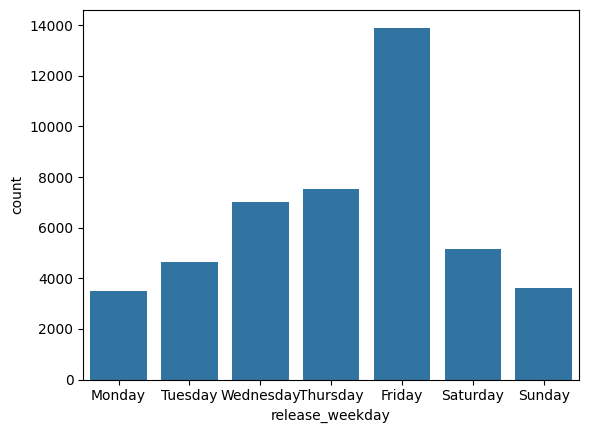

In [6]:
sns.countplot(x="release_weekday", data=move_metadata, order=WEEK_DAYS_ORDER)
plt.show()

## Задание №2

In [39]:
actors = merged_metadata.copy().explode("actors").groupby("actors")

actors_movies = actors["id"].count().rename("movies").reset_index()
actors_revenue = actors["revenue"].mean().rename("revenue").reset_index()
actor_budget = actors["budget"].mean().rename("budget").reset_index()

In [40]:
actors_summary = (
    actors_movies.merge(actors_revenue, on="actors")
    .merge(actor_budget, on="actors")
    .sort_values(by=["movies"], ascending=False)
)

short_actors_summary = actors_summary[:100]
short_actors_summary.set_index("actors", inplace=True)


print(short_actors_summary.head(100))

                   movies       revenue        budget
actors                                               
Bess Flowers          241  1.530760e+06  5.758212e+05
Christopher Lee       148  6.362870e+07  1.532515e+07
John Wayne            125  1.888752e+06  9.228830e+05
Samuel L. Jackson     123  1.391026e+08  3.947695e+07
Gérard Depardieu      110  1.134190e+07  6.813194e+06
...                   ...           ...           ...
Val Kilmer             70  3.208309e+07  1.905214e+07
Ernest Borgnine        70  6.387733e+06  4.205830e+06
Vanessa Redgrave       70  2.214314e+07  1.002571e+07
Robert Forster         70  2.030826e+07  1.167571e+07
Nick Nolte             70  3.904517e+07  1.940714e+07

[100 rows x 3 columns]


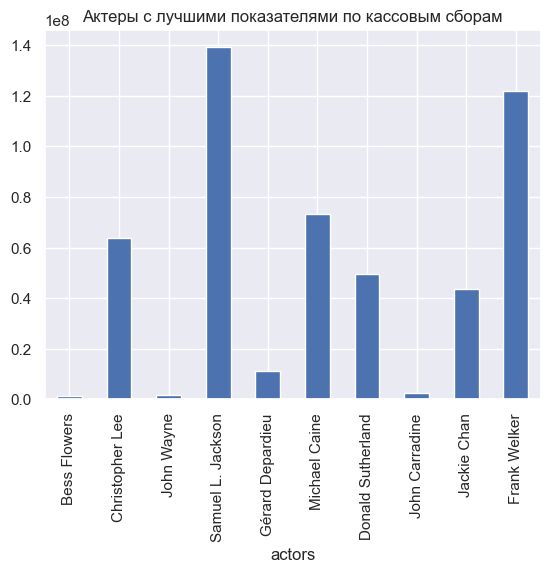

In [47]:
plt.title("Актеры с лучшими показателями по кассовым сборам")
short_actors_summary.sort_values("movies", ascending=False)["revenue"].head(10).plot(
    kind="bar"
)
plt.show()

По данному графику ничего не понять, он подходит только для того, что-бы определить имена самых "кассовых" актеров и с помощью "экспертного" мнения определить кого мы тут знаем. 

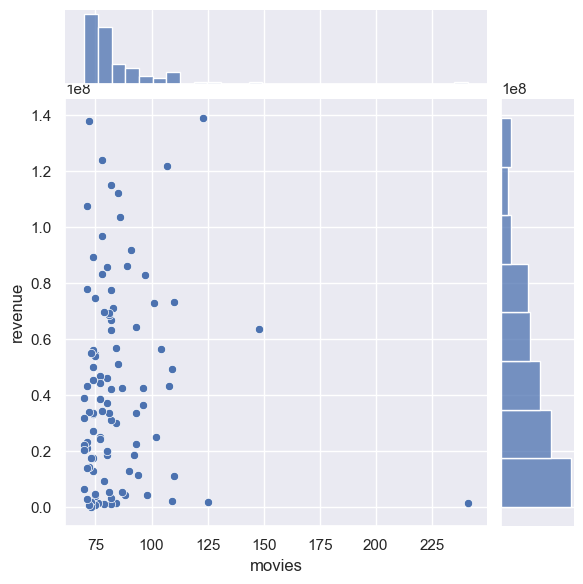

In [42]:
sns.set_theme()
sns.jointplot(x="movies", y="revenue", data=short_actors_summary)
plt.show()

По данному графику тоже не видно, каких-то явных зависимостей. Можно только сказать, что "кассовых" актеров меньше чем "не кассовых"

Попробуем визуализировать данные по цвету

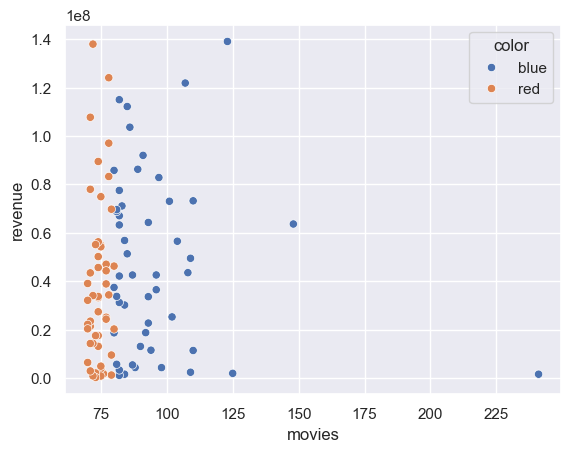

In [43]:
short_actors_summary["color"] = "blue"
short_actors_summary["color"].iloc[50:100] = "red"

sns.scatterplot(
    x="movies",
    y="revenue",
    data=short_actors_summary,
    hue="color",
)
plt.show()

И вновь явных зависимостей не выявлено

## Задание №3

По опыту из предыдущего задания попробуем повторить все шаги

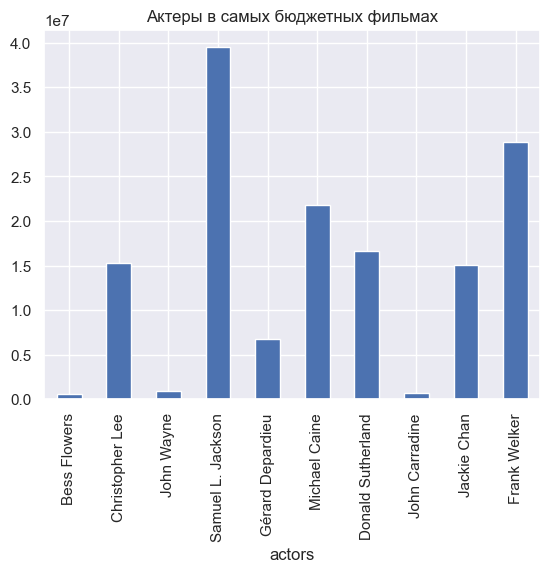

In [49]:
plt.title("Актеры в самых бюджетных фильмах")
short_actors_summary.sort_values("movies", ascending=False)["budget"].head(10).plot(
    kind="bar"
)
plt.show()

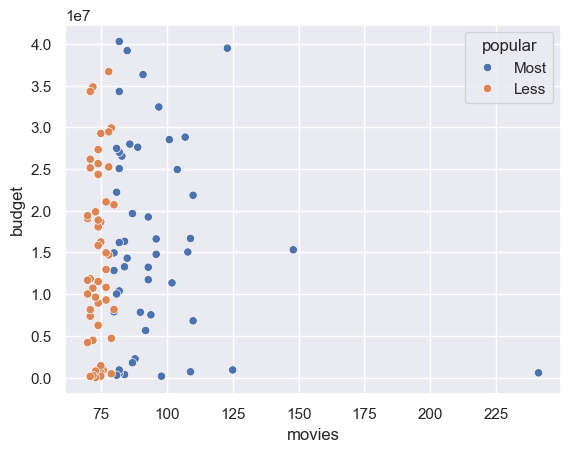

In [50]:
short_actors_summary["popular"] = "Most"
short_actors_summary["popular"].iloc[50:100] = "Less"

sns.scatterplot(
    x="movies",
    y="budget",
    data=short_actors_summary,
    hue="popular",
)
plt.show()

Здесь тоже не заметно какой либо зависимости.